# Color Commons

## Abstract

## Quick Statistics

- Total amount of texts: 8022
- **Top 5 Colors:** Red, Blue, Green, Yellow, Pink

- **How many times 'secret' was texted:**
- highly engaged users (over 15 texts)

- 
- unique users

- repreat users

- highly engaged users (over 15 texts)

- user groups/clusters
- peak use -- times of day and week

## Contents
- 1.0 User Participation
- 2.0 Message Content



In [19]:
# Basic setup
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import json
import difflib
import pickle
import re
from collections import Counter
import seaborn as sb
import calendar

# Read in a prepared dataset
df = pd.read_csv('../data/from_20170214_to_20170425.csv')
df.index = pd.to_datetime(df.SentDate)
df['datetime'] = pd.to_datetime(df.SentDate)
df.index.tz_localize('UTC').tz_convert('US/Eastern')
df['date'] = [x.date() for x in df.index]
df['hour'] = [x.hour for x in df.index]
df = df[['From', 'Body', 'SentDate', 'Status', 'datetime', 'date', 'hour']]
df['month'] = df.datetime.dt.month.apply(lambda x: calendar.month_abbr[x])
df['day'] = df.datetime.dt.day
df['Body'] = df.Body.str.lower().replace(r"\s+", "")
df['id'] = df.From

## 2.0 User Participation


In [20]:
# Total messages
print('Total messages = {}\n'.format(len(df)))

Total messages = 11285



In [21]:
# Count of unique users
print('# of unique users: {}\n'.format(len(set(df.id))))

# of unique users: 608



In [22]:
# Count of repeat users
print('# of repeat users: {}\n'.format(sum(df.id.value_counts() > 1)))

# of repeat users: 492



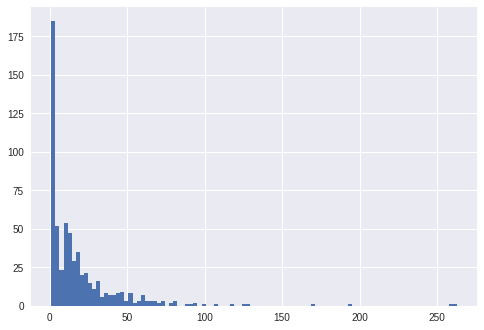

count    608.000000
mean      18.560855
std       26.431215
min        1.000000
25%        2.000000
50%       11.000000
75%       23.000000
max      263.000000
Name: id, dtype: float64

In [23]:
# A two-panel plot showing user frequency
plt.hist(df.id.value_counts(), bins = 100)
plt.show()
df.id.value_counts().describe()

In [24]:
# Read in the pickled dataset
with open('../data/napa.pickle', 'rb') as f:
    ccdf = pickle.load(f)
    
ccdf.columns = ['min_date', 'ct']
ccdf = ccdf.reset_index()

ccdf['pct'] = ccdf.ct/sum(ccdf.ct)
ccdf['cumpct'] = np.cumsum(ccdf.pct)

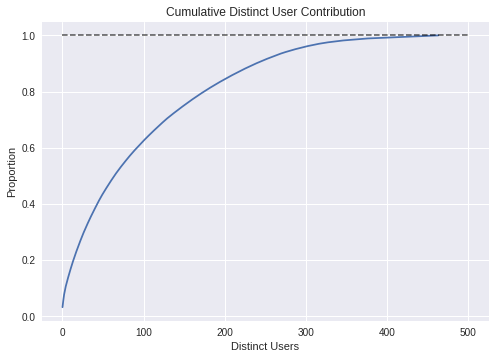

In [25]:
# Cumulative plot showing user contribution
plt.plot(ccdf.cumpct)
plt.plot([0, 500], [1, 1], color='k', linestyle='--', linewidth=2, alpha=0.5)
plt.xlabel('Distinct Users')
plt.ylabel('Proportion')
plt.title('Cumulative Distinct User Contribution')
plt.show()

In [26]:
# Use the index (a date-time) to create a column with the weekday names
df['weekday_name'] = df.index.weekday_name
df['weekday'] = df.index.weekday

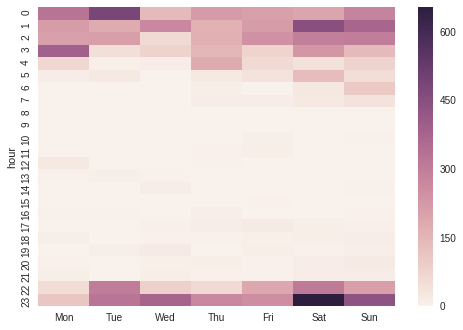

In [27]:
def make_hour_weekday_heatmap(_df, _aggfunc):
    # Use pandas pivot table to sum up counts by weekday and hour
    # This creates a 2D dataframe containing the counts
    weekday_hour = pd.pivot_table(_df, values='id', index=['hour'], columns=['weekday'], aggfunc=_aggfunc, fill_value=0)

    # Overwrite column names with abbrev
    weekday_hour.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

    # Create a heat plot with our 2D dataframe
    sb.heatmap(weekday_hour)
    plt.show()

make_hour_weekday_heatmap(df, len)

Saturday at 11p is the most popular time based on absolute counts.  We have some heavy users, which might be biasing our visualization.  We can approach this a few ways:

    (1) plot only the initial text by a user
    (2) only allow a user to contribute one text per grid cell
    (3) normalize the users text count

           id        From    Body             SentDate    Status  \
0  Aaron26151  Aaron26151    lime  2017-04-25 02:03:09  received   
1  Aaron27162  Aaron27162  orange  2017-04-24 01:17:32  received   
2   Abbie1241   Abbie1241  yellow  2017-03-01 23:37:21  received   
3   Abbie9260   Abbie9260  orange  2017-02-18 22:17:59  received   
4    Abe12277    Abe12277    pink  2017-02-25 06:01:08  received   

             datetime        date  hour month  day weekday_name  weekday  
0 2017-04-25 02:03:09  2017-04-25     2   Apr   25      Tuesday        1  
1 2017-04-24 01:17:32  2017-04-24     1   Apr   24       Monday        0  
2 2017-03-01 23:37:21  2017-03-01    23   Mar    1    Wednesday        2  
3 2017-02-18 22:17:59  2017-02-18    22   Feb   18     Saturday        5  
4 2017-02-25 06:01:08  2017-02-25     6   Feb   25     Saturday        5  


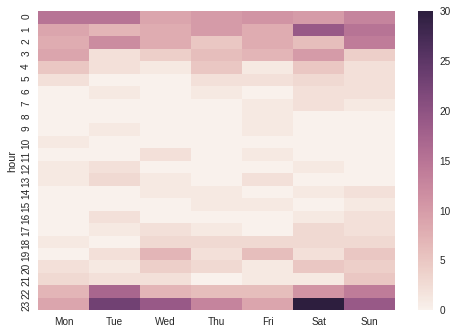

In [28]:
# (1) plot only the initial text by a user
only_first_time_user = df.groupby('id').first().reset_index() # better check to make sure that actually works
print(only_first_time_user.head())

make_hour_weekday_heatmap(only_first_time_user, len)

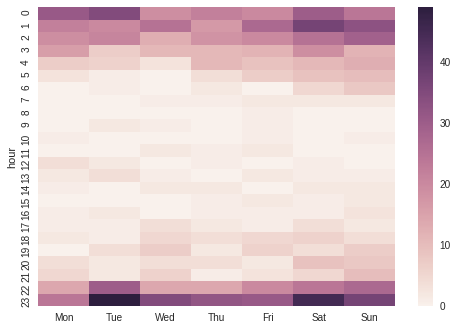

In [29]:
# (2) only allow a user to contribute one text per grid cell
def count_unique(col):
    # a quick function to return the count of unique values
    return(len(set(col)))

# Create the heatmap with our custom count_unique function
make_hour_weekday_heatmap(df, count_unique)

These all look sort of the same.  I imagine the third will look similar, so I am not going to bother making it.

In [30]:
# Top 5 colors
print('Top 5 Colors:\n{}\n'.format(df.Body.str.lower().value_counts().head(5)))

# 'secret' message
print('Count of "secret" texts: {}'.format(sum(df.Body.str.lower() == 'secret')))

# 'poop' message
print('Count of "poop" texts: {}'.format(sum(df.Body.str.lower() == 'poop')))

Top 5 Colors:
red       1037
blue       951
green      823
yellow     688
pink       606
Name: Body, dtype: int64

Count of "secret" texts: 240
Count of "poop" texts: 38


## Groups or Individuals

In [31]:
def count_unique(input_list):
    return Counter(input_list).items()

ctr = count_unique(['a', 'b', 'a'])

df.groupby('id').aggregate({'date': [count_unique, len, min, max]}).sort_values(by=('date', 'len'), ascending=False)

date       \
                                                      count_unique  len   
id                                                                        
Dorothy17737     ((2017-03-06, 33), (2017-04-15, 38), (2017-04-...  263   
Sylvia117219     ((2017-02-27, 2), (2017-04-19, 3), (2017-04-05...  259   
Adelaide216138   ((2017-02-28, 27), (2017-03-18, 4), (2017-02-2...  193   
Ida177160        ((2017-04-14, 7), (2017-03-24, 6), (2017-03-22...  170   
Angie33170       ((2017-03-08, 2), (2017-02-21, 3), (2017-04-10...  128   
Charlie16890     ((2017-04-14, 1), (2017-04-13, 20), (2017-04-1...  125   
Augustus198204   ((2017-02-21, 29), (2017-04-21, 9), (2017-02-2...  118   
Susan9452        ((2017-02-17, 1), (2017-03-31, 2), (2017-04-23...  106   
Lee73205         ((2017-04-12, 6), (2017-04-13, 13), (2017-02-1...   99   
James24898       ((2017-04-14, 10), (2017-04-11, 27), (2017-04-...   95   
Ernest216147     ((2017-04-11, 3), (2017-03-04, 15), (2017-04-0...   95   
Jane20141        ((2017-03-02, 1), (2017-04-03, 4), (2017-03-13...   92   
Claude88231      ((2017-02-19, 4), (2017-02-21, 30), (2017-02-1...   89   
Anderson25199    ((2017-02-22, 20), (2017-02-15, 34), (2017-02-...   82   
Clifford235187   ((2017-02-18, 15), (2017-02-23, 1), (2017-02-2...   82   
Fredrick17186                  ((2017-04-11, 8), (2017-04-10, 74))   82   
Eugenia24169     ((2017-02-25, 44), (2017-03-31, 2), (2017-02-2...   79   
James116249      ((2017-02-17, 22), (2017-02-21, 5), (2017-02-2...   78   
Moses20712                    ((2017-02-19, 45), (2017-02-20, 28))   73   
Nelle35160       ((2017-04-09, 19), (2017-03-10, 1), (2017-02-1...   73   
Nelson110197                                    ((2017-04-10, 72))   72   
Jean170213       ((2017-04-12, 1), (2017-04-04, 6), (2017-04-01...   71   
Roscoe233225                                    ((2017-03-30, 70))   70   
Joshua50244      ((2017-02-28, 1), (2017-03-02, 11), (2017-03-1...   68   
Rhoda137135      ((2017-04-18, 9), (2017-04-19, 3), (2017-04-22...   67   
Elizabeth139158                                 ((2017-02-18, 67))   67   
Ora10121         ((2017-02-19, 50), (2017-03-15, 2), (2017-02-2...   66   
Homer16783       ((2017-03-02, 14), (2017-03-01, 46), (2017-03-...   64   
Helena86185                                     ((2017-04-22, 64))   64   
Ellis76221       ((2017-03-01, 5), (2017-03-07, 12), (2017-02-2...   63   
...                                                            ...  ...   
Josephine218102                                  ((2017-02-19, 1))    1   
Roscoe84140                                      ((2017-02-28, 1))    1   
Amy141209                                        ((2017-03-07, 1))    1   
Rosetta4030                                      ((2017-04-14, 1))    1   
Emilie177152                                     ((2017-02-14, 1))    1   
Dora52156                                        ((2017-04-10, 1))    1   
Milton1748                                       ((2017-02-19, 1))    1   
Emily14681                                       ((2017-03-03, 1))    1   
Jessie19668                                      ((2017-02-15, 1))    1   
Ernest6436                                       ((2017-04-04, 1))    1   
Jerry23430                                       ((2017-03-22, 1))    1   
Sarah108182                                      ((2017-04-10, 1))    1   
Richard4173                                      ((2017-02-25, 1))    1   
Emery15178                                       ((2017-02-17, 1))    1   
Anna52189                                        ((2017-02-24, 1))    1   
Katie6245                                        ((2017-02-16, 1))    1   
Leah14077                                        ((2017-04-07, 1))    1   
Anton105125                                      ((2017-03-21, 1))    1   
Lee18197                                         ((2017-03-04, 1))    1   
Elizabeth136197                                  ((2017-02-14, 1))    1   
Leo6712     

In [32]:
ordered_ids = df.sort_values(by='datetime').id

In [33]:
grouped = df.groupby('date')

colors_by_date = {}

for name, group in grouped:
    colors_by_date[name.strftime("%Y%m%d")] = group.Body.as_matrix()

In [34]:
color_map = pd.read_csv('../data/rgb.txt'
                        ,sep='\t'
                        ,skiprows=[0]
                        ,names = ['color', 'hex', 'unk'])[['color', 'hex']]

In [35]:
def translate_color(color):
    try:
        trans_color = color_map[color_map.color == difflib.get_close_matches(color, color_map.color)[0]].hex.to_string(index=False)
    except IndexError:
        trans_color = '#ffffff'
    return trans_color

In [36]:
import random
#unique_days_ct = len(date_color_json.keys())
unique_days_ct = 2

colors_by_date_subset = {}
date1 = '20170218'
date2 = '20170216'
colors_by_date_subset[date1] = colors_by_date[date1]
colors_by_date_subset[date2] = colors_by_date[date2]

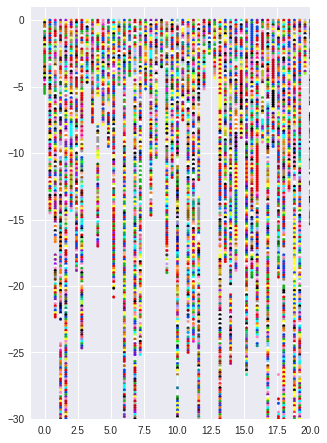

In [37]:
fig = plt.figure(figsize=[5,120]) # give plots a rectangular frame
ax = fig.add_subplot(111)
ax.set_aspect(1)
r = 0.1
x_val = 0
x_inc = 0.4
x_min = x_inc*unique_days_ct


for day, color_array in colors_by_date.items():
    for y, color in enumerate(color_array):
        try:
            clr = color_map[color_map.color == difflib.get_close_matches(color, color_map.color)[0]].hex.to_string(index=False)
            circle = plt.Circle((x_val, -y/6), r, color=clr) # create the circle with the color
        except:
            continue
        ax.add_artist(circle)
    x_val += x_inc
    
ax.set_xlim(-1, 20)
ax.set_ylim(-30, 1)
plt.show()